In [1]:
# Importing Libraries
import librosa  
import numpy as np  
import os
import tensorflow as tf
from tqdm import tqdm


In [2]:
# Utliity Functions
def extract_features(audio_path):
    data, sr = librosa.load(audio_path, res_type='kaiser_best')
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=128)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs


In [3]:
# Defining features and labels
X = []
Y = []
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, 'filtered_dataset')
emotions = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

In [4]:
# Extracting features
total_files = sum([len(files) for r, d, files in os.walk(dataset_dir)])
pbar = tqdm(total=total_files)

for emotion in emotions:
    emotion_dir = os.path.join(dataset_dir, emotion)
    for file in os.listdir(emotion_dir):
        if file.endswith('.wav'):
            audio_path = os.path.join(emotion_dir, file)
            features = extract_features(audio_path)
            X.append(features)
            Y.append(emotion)
            pbar.update()

pbar.close()

100%|██████████| 8391/8391 [21:42<00:00,  6.44it/s]  


In [5]:
# Saving Features and Labels
np.save('saved_features/data.npy', X)
np.save('saved_features/labels.npy', Y)

In [6]:
# Importing saved features
# X = np.load('saved_features/data.npy')
# Y = np.load('saved_features/labels.npy')

# Converting to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Label Encoding
from sklearn.preprocessing import LabelEncoder
lr = LabelEncoder()
Y_enc = lr.fit_transform(Y)

# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_enc, test_size=0.3, random_state=48)   


In [7]:
# Checking the encoded labels
for index, label in enumerate(lr.classes_):
    print(f'{index}: {label}')

0: Angry
1: Disgusted
2: Fearful
3: Happy
4: Neutral
5: Sad
6: Surprised


In [8]:

# Building the model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


In [9]:

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Defining the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=14, verbose=1)

In [10]:

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.3395 - loss: 2.0075 - val_accuracy: 0.4519 - val_loss: 1.3363
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4975 - loss: 1.3420 - val_accuracy: 0.5437 - val_loss: 1.1719
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5125 - loss: 1.2503 - val_accuracy: 0.5905 - val_loss: 1.0764
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5572 - loss: 1.1618 - val_accuracy: 0.5639 - val_loss: 1.0631
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5664 - loss: 1.1248 - val_accuracy: 0.6358 - val_loss: 0.9866
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5551 - loss: 1.1136 - val_accuracy: 0.6029 - val_loss: 1.0062
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5946 - loss: 1.0466 - val_accuracy: 0.6402 - val_loss: 0.9455
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6104 - loss: 1.0102 - 

In [11]:
# Evaluating the model
model.evaluate(X_test, Y_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 - loss: 0.9282


[0.9187352061271667, 0.6890389323234558]

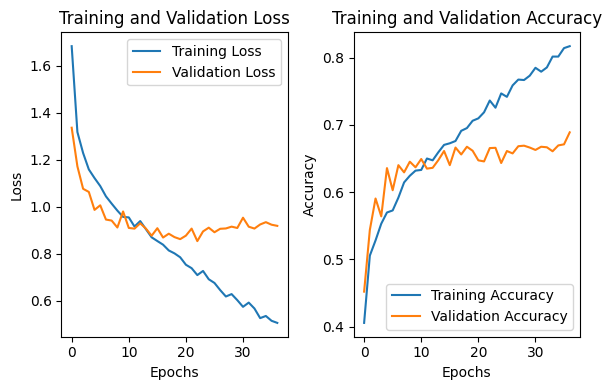

In [12]:
# Visualizing the training history
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training accuracy and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [13]:
# Saving the model
model.save('saved_model/model.keras')

In [14]:
# Making the detection function
def detect(audio_path):
    features = extract_features(audio_path)
    features = np.expand_dims(features, axis=0) # Adding a batch dimension
    pred = model.predict(features) 
    pred_index = np.argmax(pred)
    label = lr.inverse_transform([pred_index])[0]
    return label